In [100]:
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import griddata
%matplotlib inline

In [9]:
year, month = 2016, 4

# Input files

## HF radar

In [77]:
yyyy = str(year)
mm = str(month).zfill(2)
radarfile = ("http://thredds.socib.es/thredds/dodsC/hf_radar/"
            "hf_radar_ibiza-scb_codarssproc001/L1/{0}/"
            "dep0001_hf-radar-ibiza_scb-codarssproc001_L1_{1}-{2}.nc".format(yyyy, yyyy, mm))
print(radarfile)

http://thredds.socib.es/thredds/dodsC/hf_radar/hf_radar_ibiza-scb_codarssproc001/L1/2016/dep0001_hf-radar-ibiza_scb-codarssproc001_L1_2016-04.nc


## Ibiza mooring

In [78]:
mooringfile = ("http://thredds.socib.es/thredds/dodsC/mooring/"
               "currentmeter/buoy_canaldeibiza-scb_dcs002/L1/{0}/"
               "dep0001_buoy-canaldeibiza_scb-dcs002_L1_{1}-{2}.nc".format(yyyy, yyyy, mm))
print(mooringfile)

http://thredds.socib.es/thredds/dodsC/mooring/currentmeter/buoy_canaldeibiza-scb_dcs002/L1/2016/dep0001_buoy-canaldeibiza_scb-dcs002_L1_2016-04.nc


# Read the data

## Mooring

In [80]:
with netCDF4.Dataset(mooringfile) as nc:
    lon_mooring = nc.variables['LON'][:]
    lat_mooring = nc.variables['LAT'][:]
    vel = nc.variables['CUR_SPE'][:]
    direction = nc.variables['CUR_DIR'][:]
    time_mooring = nc.variables['time'][:]
    time_mooring_units = nc.variables['time'].units
u_mooring = vel * np.sin(np.deg2rad(direction))
v_mooring = vel * np.cos(np.deg2rad(direction))

## HF radar

We will interpolate (linearly) the HF radar velocity field onto the position of the Ibiza Channel mooring.

In [81]:
with netCDF4.Dataset(radarfile) as nc:
    lon_radar = nc.variables['LON'][:]
    lat_radar = nc.variables['LAT'][:]
    u_radar = nc.variables['U'][:]
    v_radar = nc.variables['V'][:]
    time_radar = nc.variables['time'][:]
    time_radar_units = nc.variables['time'].units

Extract u and v from the radar at the mooring location:<br>
we can try interpolation using [interp2d](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.interp2d.html) function or consider the radar velocities as unstructured and use [griddata](http://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html), but the nan values located near to the mooring positions cause problems.<br>
Solution: find the position of the nearest point.

In [127]:
distance_matrix = np.sqrt((llon_radar - lon_mooring)**2  + (llat_radar - lat_mooring)**2)
i, j = np.unravel_index(distance_matrix.argmin(), distance_matrix.shape)
u_radar_interp = u_radar[:, i, j]
v_radar_interp = v_radar[:, i, j]

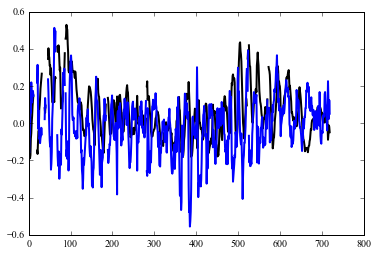

In [128]:
plt.plot(u_radar_interp)
plt.plot(v_radar_interp)
plt.show()

# Fill in gaps

There are missing values and we need to fill them.<br>
Easiest solution: linear interpolation, considering that the gaps are not too large.

In [129]:
def linear_fill(x, y):
    """Fill the gap in a time serie using linear interpolation"""
    good_values = np.where(~np.isnan(y))
    missing_values = np.where(np.isnan(y))
    y_interp = np.copy(y)
    y_interp[missing_values] = np.interp(x[missing_values], 
                                         x[good_values],
                                         y[good_values])
    return y_interp

## Energy spectrum

In [130]:
sampling_period = time[2] - time[1]
print("Sampling period = {0} {1}".format(sampling_period, time_units))

Sampling period = 3600.0 seconds since 1970-01-01 00:00:00


In [133]:
u_radar_interp_filled = linear_fill(time, u_radar_interp)
v_radar_interp_filled = linear_fill(time, v_radar_interp)

power_u = 20*np.log10(np.abs(np.fft.rfft(u_radar_interp_filled)))
power_v = 20*np.log10(np.abs(np.fft.rfft(v_radar_interp_filled)))

frq = np.linspace(0, 1/(2.*sampling_period), len(power))

## Rotary energy spectrum

Taken from https://github.com/pyoceans/python-oceans/blob/master/oceans/ff_tools/ocfis.py

In [139]:
def spec_rot(u, v):
    """
    Compute the rotary spectra from u,v velocity components
    Parameters
    ----------
    u : array_like
    zonal wind velocity [m s :sup:`-1`]
    v : array_like
    meridional wind velocity [m s :sup:`-1`]
    Returns
    -------
    cw : array_like
    Clockwise spectrum [TODO]
    ccw : array_like
    Counter-clockwise spectrum [TODO]
    puv : array_like
    Cross spectra [TODO]
    quv : array_like
    Quadrature spectra [ TODO]
    Notes
    -----
    The spectral energy at some frequency can be decomposed into two circularly
    polarized constituents, one rotating clockwise and other anti-clockwise.
    Examples
    --------
    TODO: puv, quv, cw, ccw = spec_rot(u, v)
    References
    ----------
    .. [1] J. Gonella Deep Sea Res., 833-846, 1972.
    """
    # Individual components Fourier series.
    fu, fv = list(map(np.fft.fft, (u, v)))
    # Auto-spectra of the scalar components.
    pu = fu * np.conj(fu)
    pv = fv * np.conj(fv)
    # Cross spectra.
    puv = fu.real * fv.real + fu.imag * fv.imag
    # Quadrature spectra.
    quv = -fu.real * fv.imag + fv.real * fu.imag
    # Rotatory components
    # TODO: Check the division, 4 or 8?
    cw = (pu + pv - 2 * quv) / 4.
    ccw = (pu + pv + 2 * quv) / 4.
    N = len(u)
    F = np.arange(0, N) / N
    return puv, quv, cw, ccw, F

In [140]:
puv, quv, cw, ccw, F = spec_rot(u_radar_interp_filled, v_radar_interp_filled)

# Plots

## Energy spectra for u and v 

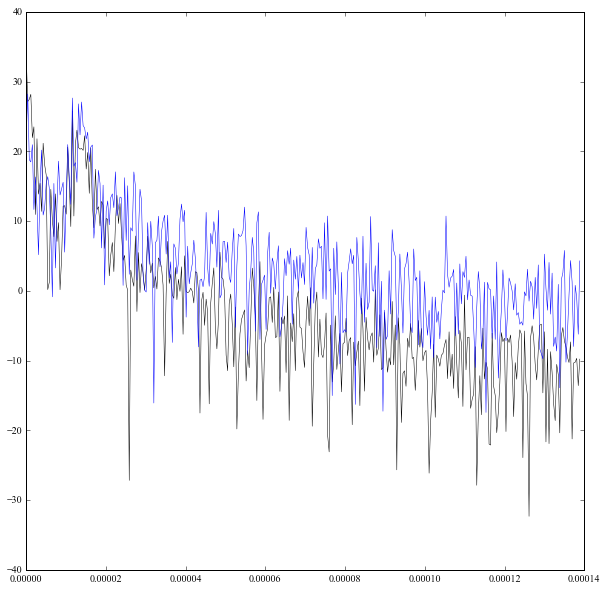

In [135]:
fig = plt.figure(figsize=(10, 10))
plt.plot(frq, power_u, 'k-', lw=0.5)
plt.plot(frq, power_v, 'b-', lw=0.5)
plt.show()

## Rotary spectrum 

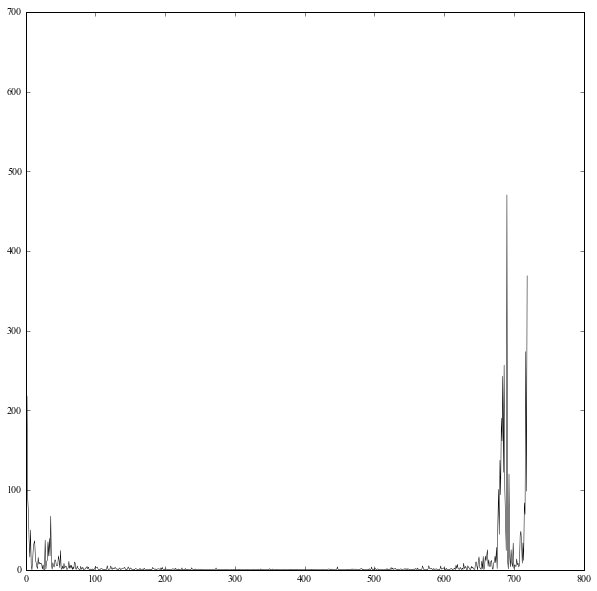

In [143]:
fig = plt.figure(figsize=(10, 10))
plt.plot(ccw, lw=0.5)
plt.show()

# Tests...

Check if the filled time series is ok

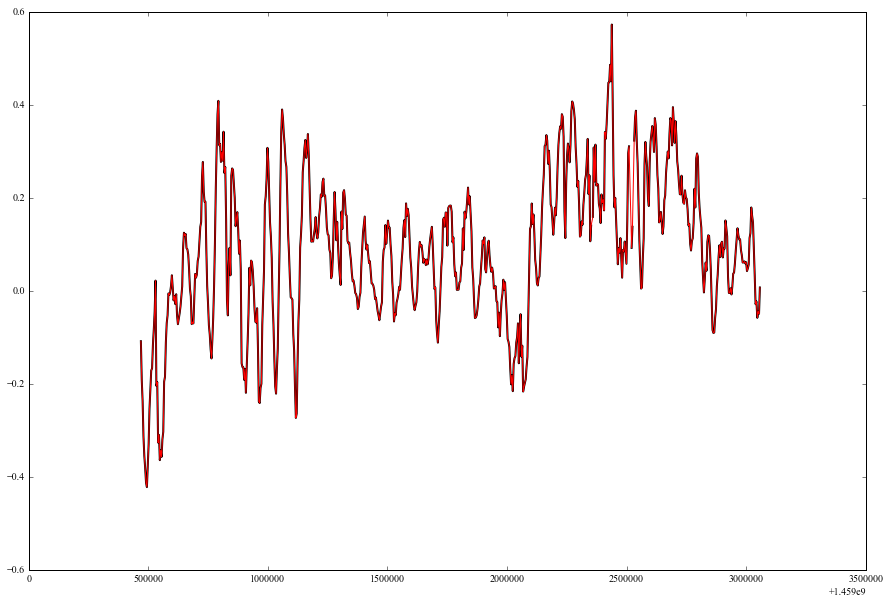

In [67]:
u2plot_interp = linear_fill(time, u2plot)

fig = plt.figure(figsize=(15, 10))
plt.plot(time, u2plot, 'k', lw=2)
plt.plot(time, u2plot_interp, 'r-', lw=1)
plt.show()

Check the mooring position

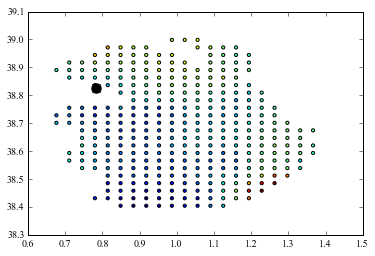

In [97]:
plt.scatter(llon_radar, llat_radar, c=u_radar[0, :, :], s=10)
plt.plot(lon_mooring, lat_mooring, 'ko', ms=10)
plt.show()